<a href="https://colab.research.google.com/github/makrez/BioinformaticsTools/blob/master/Variational_Autoencoder_16S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Autoencoder

In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
!pip install biopython
from Bio import SeqIO
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
!pip install umap-learn
import umap
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
!pip install torchviz
from torchviz import make_dot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=71be43f0351522ae48b9aad57c0d22da633d3e642c02864bdab679fc9c6c10ac
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=506b0f7c68bb302c7ba4b9bc146d023c82f29a31b89b2a90beb454755482e2e4
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d

Mount drive

In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data

In [ ]:
class hot_dna:
    def __init__(self, sequence):
        sequence = sequence.upper()
        self.sequence = self._preprocess_sequence(sequence)
        self.category_mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'U': 3, '-': 4, 'N': 5}
        self.onehot = self._onehot_encode(self.sequence)

    def _preprocess_sequence(self, sequence):
        ambiguous_bases = {'R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V'}
        new_sequence = ""
        for base in sequence:
            if base in ambiguous_bases:
                new_sequence += 'N'
            else:
                new_sequence += base
        return new_sequence

    def _onehot_encode(self, sequence):
        integer_encoded = np.array([self.category_mapping[char] for char in sequence]).reshape(-1, 1)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        
        full_onehot_encoded = np.zeros((len(sequence), 6))
        full_onehot_encoded[:, :onehot_encoded.shape[1]] = onehot_encoded
        
        return full_onehot_encoded

flatted_sequence = list()
sequence_labels = list()

alignment_length = 1500

with open('/content/drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        label = str(record.description).rsplit(';', 1)[-1]
        seq_hot = hot_dna(str(record.seq)[10:alignment_length+10]).onehot
        
        if len(seq_hot) == alignment_length:
            flatted_sequence.append(seq_hot)
            sequence_labels.append(label)

In [4]:
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index]

Build the Variational autoencoder

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_length, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.input_length = input_length

        # Encoding layers
        self.encoder = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2)
        )

        self.encoder_output_dim = 256 * 93
        self.fc_mu = nn.Linear(self.encoder_output_dim, latent_dim)
        self.fc_var = nn.Linear(self.encoder_output_dim, latent_dim)

        # Decoding layers
        self.decoder_input_dim = self.encoder_output_dim
        self.fc_dec = nn.Linear(latent_dim, self.decoder_input_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(32, 32, kernel_size=753, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(32, 6, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )


        # Initialize weights
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
            nn.init.kaiming_normal_(m.weight)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(x.size(0), 256, -1)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

def vae_loss(x, x_recon, mu, log_var):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


Train the model

In [6]:
def train_model(model, optimizer, train_dataloader, val_dataloader, device, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        val_loss = 0.0

        # Training loop
        model.train()
        for batch_idx, data in enumerate(train_dataloader):
            # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
            data = data.permute(0, 2, 1)
            data = data.float().to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            x_recon, mu, log_var = model(data)

            # Compute the loss
            loss = vae_loss(data, x_recon, mu, log_var)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the training loss
            train_loss += loss.item() * data.size(0)

        # Print the average training loss for the epoch
        train_loss /= len(train_dataloader.dataset)

        # Validation loop
        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(val_dataloader):
              # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
              data = data.permute(0, 2, 1)
              data = data.float().to(device)

              # Forward pass
              x_recon, mu, log_var = model(data)

              # Compute the loss
              loss = vae_loss(data, x_recon, mu, log_var)

              # Update the validation loss
              val_loss += loss.item() * data.size(0)

        val_loss /= len(val_dataloader.dataset)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))
        
        # Append the training loss to the list
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

Plotting Functions


In [29]:
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

def plot_latent_space(model, device, flatted_sequence, sequence_labels, latent_space_dim, hyperparameters):
    model.eval()

    latent_vectors = []
    labels = []

    for sequence, label in zip(flatted_sequence, sequence_labels):
        sequence = torch.from_numpy(sequence).unsqueeze(0).permute(0, 2, 1)
        sequence = sequence.float().to(device)

        mu, _ = model.encode(sequence)
        mu = mu.detach().cpu().numpy()

        latent_vectors.append(mu)
        labels.append(label)

    latent_vectors_array = np.array(latent_vectors).squeeze()

    # Apply UMAP dimensionality reduction
    if latent_space_dim > 2:
        umap_model = umap.UMAP()
        umap_coords = umap_model.fit_transform(latent_vectors_array)
    else:
        umap_coords = latent_vectors_array

    # Apply PCA dimensionality reduction
    pca_model = PCA(n_components=2)
    pca_coords = pca_model.fit_transform(latent_vectors_array)

    unique_labels = set(labels)
    color_dict = {label: plt.cm.tab20(i) for i, label in enumerate(unique_labels)}

    # Create legend elements
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[label], markersize=10, label=label) for label in unique_labels]

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    for ax, coords, method in zip(axes, [umap_coords, pca_coords], ["UMAP", "PCA"]):
        for label in unique_labels:
            indices = [i for i, x in enumerate(labels) if x == label]
            coords_subset = coords[indices]
            color = color_dict[label]

            ax.scatter(coords_subset[:, 0], coords_subset[:, 1], color=color, label=label)
        
        ax.set_title(f"{method} | Latent Dim: {hyperparameters['latent_dim']} | Learning Rate: {hyperparameters['learning_rate']} | Epochs: {hyperparameters['n_epochs']}")

    # Add the legend to the figure in the middle of the two subplots
    fig.legend(handles=legend_elements, loc='center right')

    os.makedirs(os.path.join(os.getcwd(), "vae_plots"), exist_ok=True)
    filename = f"latent_dim_{hyperparameters['latent_dim']}_lr_{hyperparameters['learning_rate']}_n_epochs_{hyperparameters['n_epochs']}.png"
    plt.savefig(os.path.join(os.getcwd() , "vae_plots", filename), bbox_inches="tight")

    plt.show()



def plot_loss(train_losses, val_losses, hyperparameters):
    plt.figure()
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Latent Dim: {hyperparameters['latent_dim']} | Learning Rate: {hyperparameters['learning_rate']} | Epochs: {hyperparameters['n_epochs']}")
    plt.legend()
    os.makedirs(os.path.join(os.getcwd(), "vae_plots"), exist_ok=True)
    filename = f"loss_latent_dim_{hyperparameters['latent_dim']}_lr_{hyperparameters['learning_rate']}_n_epochs_{hyperparameters['n_epochs']}.png"
    plt.savefig(os.path.join(os.getcwd() , "vae_plots", filename), bbox_inches="tight")
    plt.show()

Main function

Epoch: 1 	Training Loss: 81443.746612 	Validation Loss: 11276.936130
Epoch: 2 	Training Loss: 8323.361440 	Validation Loss: 5649.511189


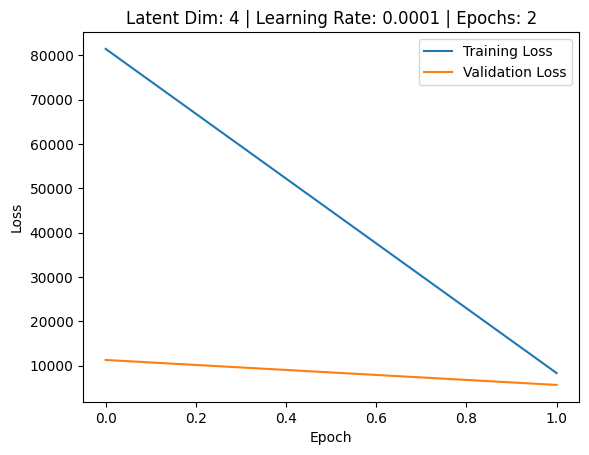

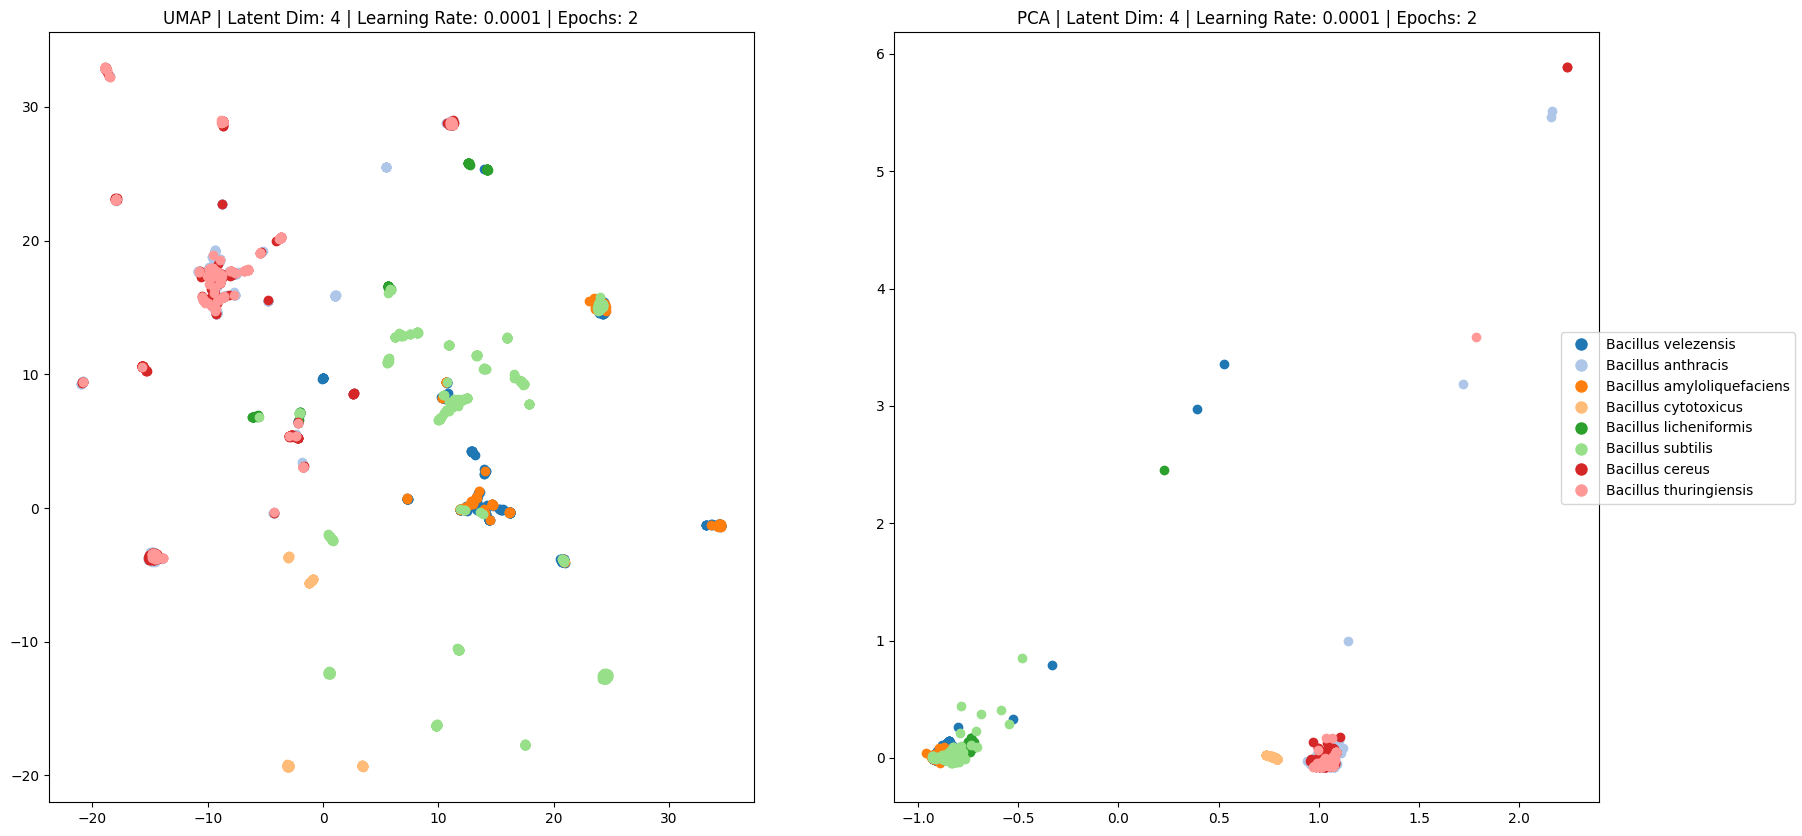

In [28]:
def main(alignment_length, latent_dim, learning_rate, n_epochs): #, architecture_name):
    # Instantiate the model with the chosen architecture
    model = VariationalAutoencoder(input_length=alignment_length, latent_dim=latent_dim) #, architecture=architectures[architecture_name])
    model = model.to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the dataloader
    dataset = SequenceDataset(flatted_sequence)
    
    # Split the dataset into training and validation sets
    train_set, val_set = train_test_split(dataset, test_size=0.1)
    
    train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)

    # Train the model
    train_losses, val_losses = train_model(model, optimizer, train_dataloader, val_dataloader, device, n_epochs)

    # Define the hyperparameters dictionary
    hyperparameters = {
        'latent_dim': latent_dim,
        'learning_rate': learning_rate,
        'n_epochs': n_epochs
    }

    plot_loss(train_losses, val_losses, hyperparameters)
    
    # Plot the latent space
    plot_latent_space(model, device, flatted_sequence, sequence_labels, latent_dim, hyperparameters)

if __name__ == '__main__':

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    alignment_length = 1500
    n_epochs = 2

    latent_dims = [4]
    learning_rates = [0.0001]

    for latent_dim in latent_dims:
        for learning_rate in learning_rates:
              model = main(alignment_length, latent_dim, learning_rate, n_epochs)
              del model
              torch.cuda.empty_cache()